# Optimal Savings (Numba version)

We consider an optimal savings problem with CRRA utility, with budget constraint

$$ W_{t+1} + C_t \leq R W_t + Y_t $$

We assume that income $(Y_t)$ is a discretized AR(1) process.

The right-hand side of the Bellman equation is 

$$   B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′). $$

where

$$   u(c) = \frac{c^{1-\gamma}}{1-\gamma} $$

In [1]:
from collections import namedtuple
import numpy as np
import quantecon as qe
from numba import njit, prange, int32
import matplotlib.pyplot as plt

In [2]:
def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25,         # Print at multiples
                      verbose=False):        
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

## Model primitives

In [3]:
# A namedtuple definition for storing parameters and grids
Model = namedtuple('Model', 
                    ('β', 'R', 'γ', 'w_grid', 'y_grid', 'Q'))

In [4]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2.5,                     # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid side
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns an instance of Model that
    contains data for the optimal savings problem.
    """
    w_grid = np.linspace(w_min, w_max, w_size)  
    mc = qe.tauchen(ρ, ν, n=y_size)
    y_grid, Q = np.exp(mc.state_values), mc.P
    return Model(β=β, R=R, γ=γ, w_grid=w_grid, y_grid=y_grid, Q=Q)

## Operators

In [5]:
@njit
def B(i, j, ip, v, model):
    """
    The right-hand side of the Bellman equation with candidate value v and
    arguments y[i], z[j], yp[ip].

    """
    β, R, γ, w_grid, y_grid, Q = model
    w, y, wp = w_grid[i], y_grid[j], w_grid[ip]
    c = R * w + y - wp
    if c > 0:
        return c**(1 - γ) / (1 - γ) + β * np.dot(v[ip, :], Q[j, :]) 
    return - np.inf

In [6]:
@njit(parallel=True)
def T_σ(v, σ, model):
    "The policy operator."
    w_size, y_size = len(model.w_grid), len(model.y_grid)
    v_new = np.empty_like(v)
    for i in prange(w_size):
        for j in range(y_size):
            v_new[i, j] = B(i, j, σ[i, j], v, model)
    return v_new

In [7]:
@njit(parallel=True)
def T(v, model):
    "The Bellman operator."
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    v_new = np.empty_like(v)
    for i in prange(w_size):
        for j in range(y_size):
            max_val = -np.inf
            for ip in range(w_size):
                val = B(i, j, ip, v, model)
                if val > max_val:
                    max_val = val
            v_new[i, j] = max_val
    return v_new

In [8]:
@njit(parallel=True)
def get_greedy(v, model):
    "Compute a v-greedy policy."
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    σ = np.empty_like(v, dtype=int32)
    for i in prange(w_size):
        for j in range(y_size):
            max_val = -np.inf
            for ip in range(w_size):
                val = B(i, j, ip, v, model)
                if val > max_val:
                    max_val = val
                    argmax_index = ip
            σ[i, j] = argmax_index
    return σ

In [9]:
@njit(parallel=True)
def get_value(σ, model):
    "Get the value v_σ of policy σ."
    # Unpack and set up
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    n = w_size * y_size
    # Function to extract (i, j) from m = i + (j-1)*w_size"
    def single_to_multi(m):
        i = m // y_size
        j = m - y_size * i
        return i, j
    # Allocate and create single index versions of P_σ and r_σ
    P_σ = np.zeros((n, n))
    r_σ = np.zeros(n)
    for m in prange(n):
        i, j = single_to_multi(m)
        w, y, wp = w_grid[i], y_grid[j], w_grid[σ[i, j]]
        c = R * w + y - wp
        r_σ[m] = c**(1 - γ) / (1 - γ) 
        for mp in range(n):
            ip, jp = single_to_multi(mp)
            if ip == σ[i, j]:
                P_σ[m, mp] = Q[j, jp]
    # Solve for the value of σ 
    v_σ = np.linalg.solve(np.identity(n) - β * P_σ, r_σ)
    # Return as multi-index array
    return np.reshape(v_σ, (w_size, y_size))

## Solvers

In [10]:
def value_iteration(model, tol=1e-5):
    "Implements VFI."
    vz = np.zeros((len(model.w_grid), len(model.y_grid)))
    v_star = successive_approx(lambda v: T(v, model), vz, tolerance=tol)
    return get_greedy(v_star, model)

In [11]:
def policy_iteration(model):
    "Howard policy iteration routine."
    w_size, y_size = len(model.w_grid), len(model.y_grid)
    σ = np.zeros((w_size, y_size), dtype=int)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = np.max(np.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return σ

In [12]:
def optimistic_policy_iteration(model, tol=1e-5, m=100):
    "Implements the OPI routine."
    v = np.zeros((len(model.w_grid), len(model.y_grid)))
    error = tol + 1
    while error > tol:
        last_v = v
        σ = get_greedy(v, model)
        for _ in range(m):
            v = T_σ(v, σ, model)
        error = np.max(np.abs(v - last_v))
    return get_greedy(v, model)

## Tests

In [13]:
model = create_consumption_model()

In [14]:
print("Starting HPI.")
qe.tic()
out = policy_iteration(model)
elapsed = qe.toc()
print(out)
print(f"HPI completed in {elapsed} seconds.")

Starting HPI.
Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
TOC: Elapsed: 0:02:46.96
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
HPI completed in 166.9668378829956 seconds.


In [15]:
print("Starting VFI.")
qe.tic()
out = value_iteration(model)
elapsed = qe.toc()
print(out)
print(f"VFI completed in {elapsed} seconds.")

Starting VFI.
TOC: Elapsed: 0:00:19.38
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
VFI completed in 19.385271787643433 seconds.


In [16]:
print("Starting OPI.")
qe.tic()
out = optimistic_policy_iteration(model, m=5)
elapsed = qe.toc()
print(out)
print(f"OPI completed in {elapsed} seconds.")

Starting OPI.
TOC: Elapsed: 0:00:5.41
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
OPI completed in 5.41820502281189 seconds.


## Plots

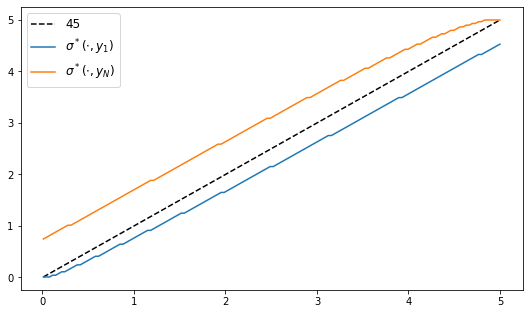

In [17]:
fontsize=12
model = create_consumption_model()
β, R, γ, w_grid, y_grid, Q = model
σ_star = optimistic_policy_iteration(model)
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star[:, 1]], label="$\\sigma^*(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star[:, -1]], label="$\\sigma^*(\cdot, y_N)$")
ax.legend(fontsize=fontsize)
plt.show()

Running Howard policy iteration.
Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
TOC: Elapsed: 0:02:49.14
PI completed in 169.141850233078 seconds.
Running value function iteration.
TOC: Elapsed: 0:00:18.66
VFI completed in 18.662906408309937 seconds.
Running optimistic policy iteration with m=5.
TOC: Elapsed: 0:00:4.55
OPI with m=5 completed in 4.556206703186035 seconds.
Running optimistic policy iteration with m=105.
TOC: Elapsed: 0:00:0.78
OPI with m=105 completed in 0.7834696769714355 seconds.
Running optimistic policy iteration with m=205.
TOC: Elapsed: 0:00:1.04
OPI with m=205 completed in 1.042391300201416 seconds.
Running optimistic policy iteration with m=305.
TOC: Elapsed: 0:00:1.36
OPI with m=305 completed in 1.3633811473846436 seconds.
Running

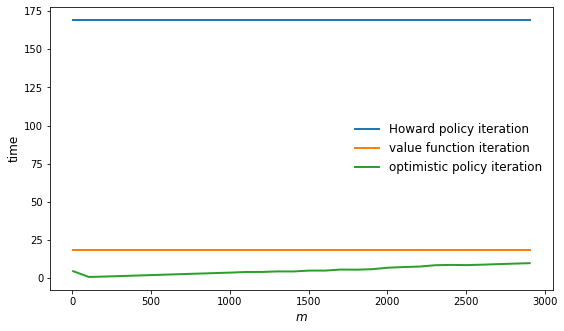

In [18]:
m_vals = range(5, 3000, 100)
model = create_consumption_model()
print("Running Howard policy iteration.")
qe.tic()
σ_pi = policy_iteration(model)
pi_time = qe.toc()
print(f"PI completed in {pi_time} seconds.")
print("Running value function iteration.")
qe.tic()
σ_vfi = value_iteration(model, tol=1e-5)
vfi_time = qe.toc()
print(f"VFI completed in {vfi_time} seconds.")
assert np.all(σ_vfi == σ_pi), "Warning: VFI policy deviated from true policy."
opi_times = []
for m in m_vals:
    print(f"Running optimistic policy iteration with m={m}.")
    qe.tic()
    σ_opi = optimistic_policy_iteration(model, m=m, tol=1e-5)
    opi_time = qe.toc()
    print(f"OPI with m={m} completed in {opi_time} seconds.")
    assert np.all(σ_opi == σ_pi), "Warning: OPI policy deviated."
    opi_times.append(opi_time)
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(m_vals, np.full(len(m_vals), pi_time), 
        lw=2, label="Howard policy iteration")
ax.plot(m_vals, np.full(len(m_vals), vfi_time), 
        lw=2, label="value function iteration")
ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
ax.legend(fontsize=fontsize, frameon=False)
ax.set_xlabel("$m$", fontsize=fontsize)
ax.set_ylabel("time", fontsize=fontsize)
plt.show()